#### Імпорт необхідних бібліотек

In [1]:
import calendar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Union
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

sns.set(style="whitegrid")

#### Попередній оглад формату вхідних даних

In [2]:
!head -n 10 Data_Set_3.csv

OrderDate,Region,Rep,Item,Units,Unit Cost,Total
9/1/14,Central,Smith,Desk,2,"  125,00 ","  250,00 "
6/17/15,Central,Kivell,Desk,5,"  125,00 ","  625,00 "
9/10/15,Central,Gill,Pencil,7,"  1,29 ","  9,03 "
11/17/15,Central,Jardine,Binder,11,"  4,99 ","  54,89 "
10/31/15,Central,Andrews,Pencil,14,"  1,29 ","  18,06 "
2/26/14,Central,Gill,Pen,27,"  19,99 ","  539,73 "
10/5/14,Central,Morgan,Binder,28,"  8,99 ","  251,72 "
12/21/15,Central,Andrews,Binder,28,"  4,99 ","  139,72 "
2/9/14,Central,Jardine,Pencil,36,"  4,99 ","  179,64 "


#### Імпорт вхідних даних у DataFrame та їх очищення/перетворення

In [3]:
def clean_and_convert_to_numeric(value: str) -> Union[np.int64, np.float64, pd.NA]:
    try:
        cleaned_value = value.strip().replace(u"\xa0", u"").replace(",", ".")
        return pd.to_numeric(cleaned_value, errors="coerce")
    except (TypeError, ValueError):
        return pd.NA

df = pd.read_csv("Data_Set_3.csv", index_col="OrderDate", parse_dates=["OrderDate"], date_format="%m/%d/%y")
df["Unit Cost"] = df["Unit Cost"].apply(clean_and_convert_to_numeric)
df["Total"] = df["Total"].apply(clean_and_convert_to_numeric)

df.head(10)

,Region,Rep,Item,Units,Unit Cost,Total
OrderDate,,,,,,
2014-09-01,Central,Smith,Desk,2,125.00,250.00
2015-06-17,Central,Kivell,Desk,5,125.00,625.00
2015-09-10,Central,Gill,Pencil,7,1.29,9.03
2015-11-17,Central,Jardine,Binder,11,4.99,54.89
2015-10-31,Central,Andrews,Pencil,14,1.29,18.06
2014-02-26,Central,Gill,Pen,27,19.99,539.73
2014-10-05,Central,Morgan,Binder,28,8.99,251.72
2015-12-21,Central,Andrews,Binder,28,4.99,139.72
2014-02-09,Central,Jardine,Pencil,36,4.99,179.64


#### Базова інформація про структуру / вміст DataFrame

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43 entries, 2014-09-01 to 2015-09-27
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Region     43 non-null     object 
 1   Rep        43 non-null     object 
 2   Item       43 non-null     object 
 3   Units      43 non-null     int64  
 4   Unit Cost  43 non-null     float64
 5   Total      43 non-null     float64
dtypes: float64(2), int64(1), object(3)
memory usage: 2.4+ KB


#### Статистичні показники числових та категоріальних даних

In [5]:
df.describe(include="all")

,Region,Rep,Item,Units,Unit Cost,Total
count,43,43,43,43.000000,43.000000,43.000000
unique,3,11,5,NaN,NaN,NaN
top,Central,Jones,Binder,NaN,NaN,NaN
freq,24,8,15,NaN,NaN,NaN
mean,NaN,NaN,NaN,49.325581,20.308605,456.462326
std,NaN,NaN,NaN,30.078248,47.345118,447.022104
min,NaN,NaN,NaN,2.000000,1.290000,9.030000
25%,NaN,NaN,NaN,27.500000,3.990000,144.590000
50%,NaN,NaN,NaN,53.000000,4.990000,299.400000
75%,NaN,NaN,NaN,74.500000,17.990000,600.180000


#### Сумарні продажі у кожному регіоні

In [6]:
region_sales = df.groupby("Region")["Total"].sum().reset_index()
region_sales

,Region,Total
0,Central,11139.07
1,East,6002.09
2,West,2486.72


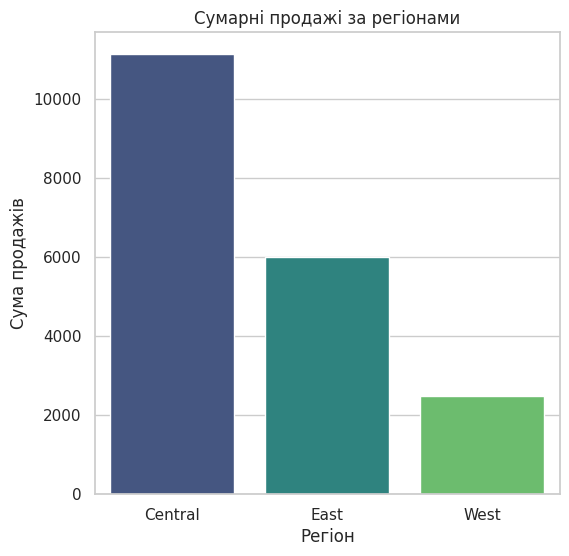

In [7]:
plt.figure(figsize=(6, 6))
sns.barplot(x="Region", y="Total", hue="Region", data=region_sales, palette="viridis")
plt.title("Сумарні продажі за регіонами")
plt.xlabel("Регіон")
plt.ylabel("Сума продажів")
plt.show()

#### Середня сума продажів у кожному регіоні

In [8]:
region_avg = df.groupby("Region")["Total"].mean().reset_index()
region_avg

,Region,Total
0,Central,464.127917
1,East,461.699231
2,West,414.453333


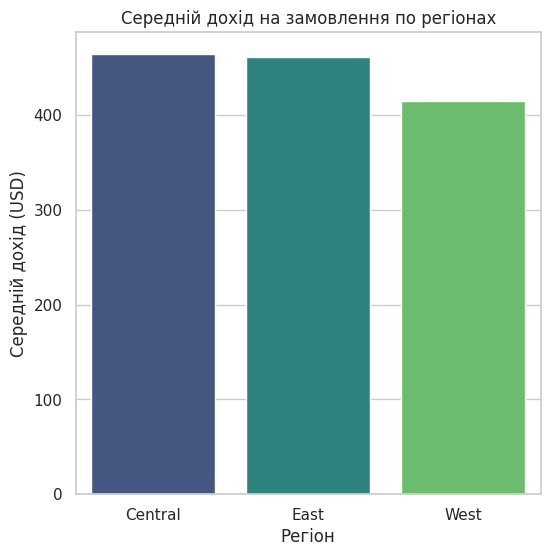

In [9]:
plt.figure(figsize=(6, 6))
sns.barplot(x="Region", y="Total", hue="Region", data=region_avg, palette="viridis")
plt.title("Середній дохід на замовлення по регіонах")
plt.ylabel("Середній дохід (USD)")
plt.xlabel("Регіон")
plt.show()

In [10]:
df["Region"].value_counts()

Region
Central    24
East       13
West        6
Name: count, dtype: int64

#### Загальна сума продажів і кількість замовлень кожного представника

In [11]:
rep_data = df.groupby("Rep").agg(
    Total=("Total", "sum"),
    OrderCount=("Rep", "size")
).reset_index().sort_values(by="Total", ascending=False)

rep_data

,Rep,Total,OrderCount
5,Kivell,3109.44,4
7,Parent,3102.30,3
3,Jardine,2812.19,5
4,Jones,2363.04,8
1,Gill,1749.87,5
8,Smith,1641.43,3
6,Morgan,1387.77,3
9,Sorvino,1283.61,4
10,Thompson,1203.11,2
2,Howard,536.75,2


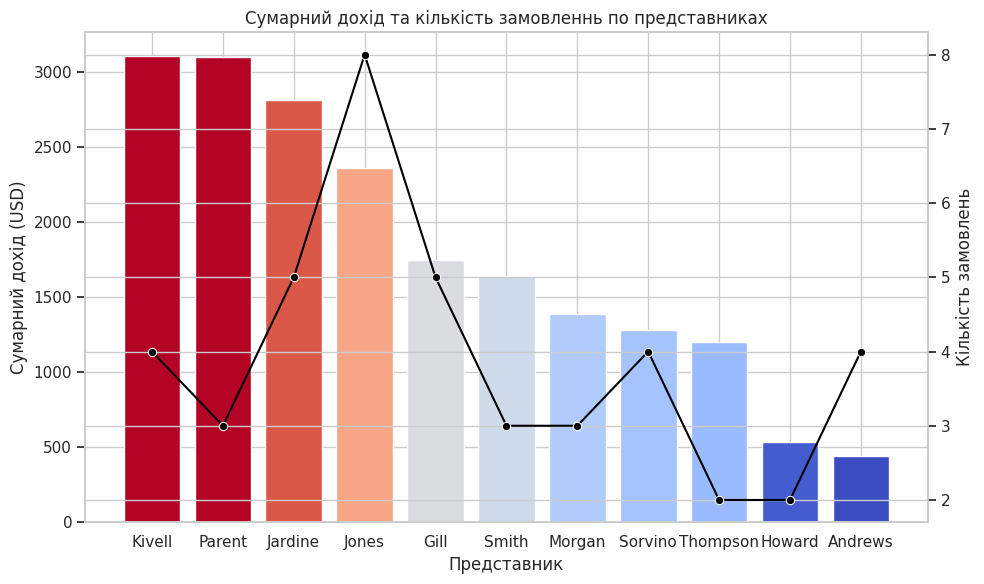

In [12]:
total = rep_data["Total"]
norm = plt.Normalize(total.min(), total.max())(total)
colors = plt.cm.coolwarm(norm)

fig, ax1 = plt.subplots(figsize=(10, 6))
bars = ax1.bar(rep_data["Rep"], rep_data["Total"], color=colors)
ax1.set_xlabel("Представник")
ax1.set_ylabel("Сумарний дохід (USD)")

ax2 = ax1.twinx()
sns.lineplot(x=rep_data["Rep"], y=rep_data["OrderCount"], ax=ax2, color="black", marker="o")
ax2.set_ylabel("Кількість замовлень")

plt.title("Сумарний дохід та кількість замовленнь по представниках")
plt.tight_layout()
plt.show()

#### Зальна сума продажів і кількість кожного товару

In [13]:
item_data = df.groupby("Item").agg({"Total": "sum", "Units": "sum"}).reset_index()
item_data

,Item,Total,Units
0,Binder,9577.65,722
1,Desk,1700.00,10
2,Pen,2045.22,278
3,Pen Set,4169.87,395
4,Pencil,2135.14,716


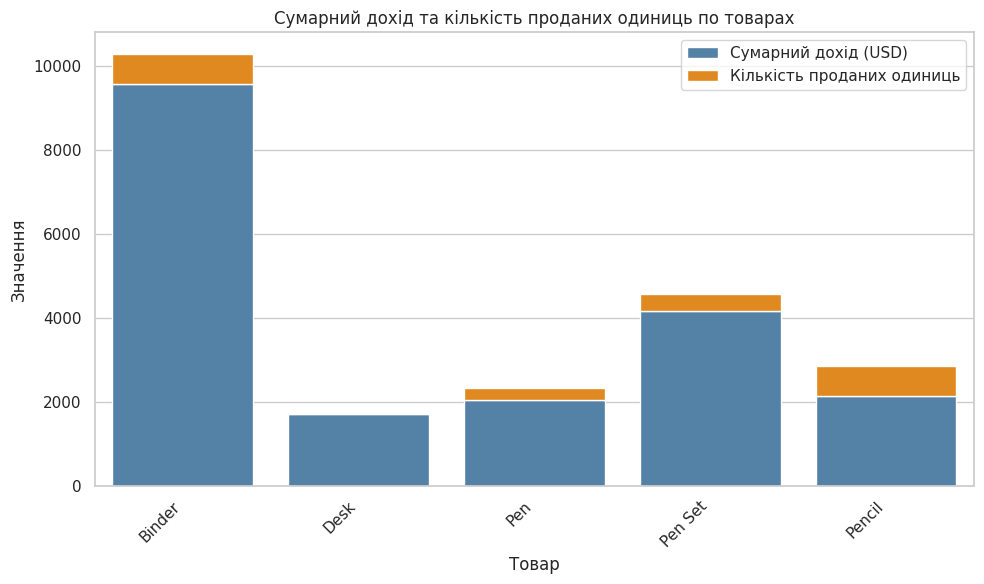

In [14]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Item", y="Total", data=item_data, color="steelblue", label="Сумарний дохід (USD)")
sns.barplot(x="Item", y="Units", data=item_data, color="darkorange", label="Кількість проданих одиниць", bottom=item_data["Total"])
plt.title("Сумарний дохід та кількість проданих одиниць по товарах")
plt.xlabel("Товар")
plt.ylabel("Значення")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

#### Загальний дохід по рокам

In [15]:
df["Year"] = df.index.year
df["Month"] = df.index.month
df["Day"] = df.index.day
df["Weekday"] = df.index.dayofweek

year_sales = df.groupby("Year")["Total"].sum().reset_index()
year_sales

,Year,Total
0,2014,9258.34
1,2015,10369.54


#### Середній місячний дохід

In [16]:
month_sales = df.groupby("Month")["Total"].mean().reset_index()
month_sales["MonthName"] = month_sales["Month"].map({i: calendar.month_name[i] for i in range(1, 13)})
month_sales

,Month,Total,MonthName
0,1,534.030000,January
1,2,511.082500,February
2,3,185.623333,March
3,4,264.757500,April
4,5,325.087500,May
5,6,537.833333,June
6,7,668.307500,July
7,8,668.516667,August
8,9,166.527500,September
9,10,496.142500,October


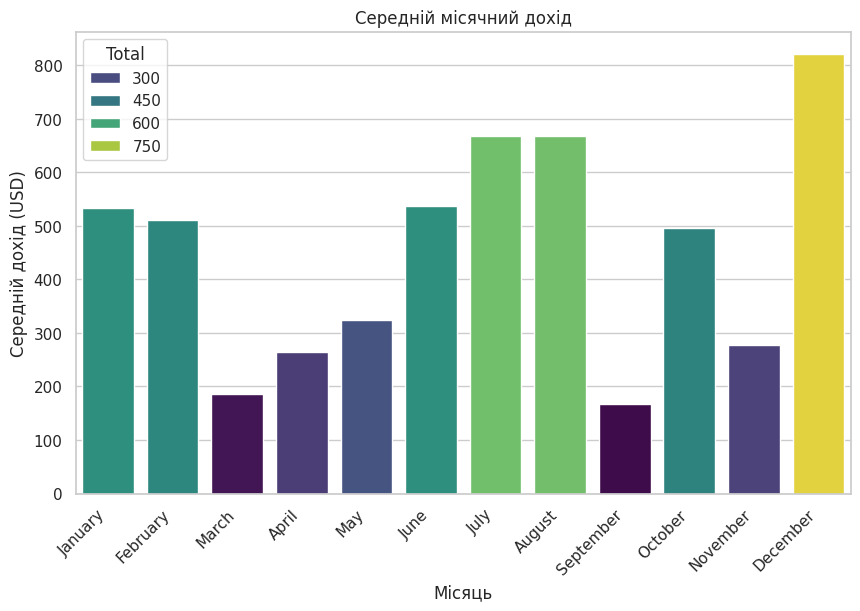

In [17]:
plt.figure(figsize=(10, 6))
sns.barplot(x="MonthName", y="Total", hue="Total", data=month_sales, palette="viridis")
plt.title("Середній місячний дохід")
plt.xlabel("Місяць")
plt.ylabel("Середній дохід (USD)")
plt.xticks(rotation=45, ha="right")
plt.show()

#### Середній дохід по дням тижня

In [18]:
sales_per_weekday = df.groupby("Weekday")["Total"].mean().reset_index()
sales_per_weekday["WeekdayName"] = sales_per_weekday["Weekday"].map({i: calendar.day_name[i] for i in range(0, 7)})
sales_per_weekday

,Weekday,Total,WeekdayName
0,0,502.167143,Monday
1,1,564.828333,Tuesday
2,2,558.096667,Wednesday
3,3,301.660000,Thursday
4,4,571.105000,Friday
5,5,165.395000,Saturday
6,6,524.366667,Sunday


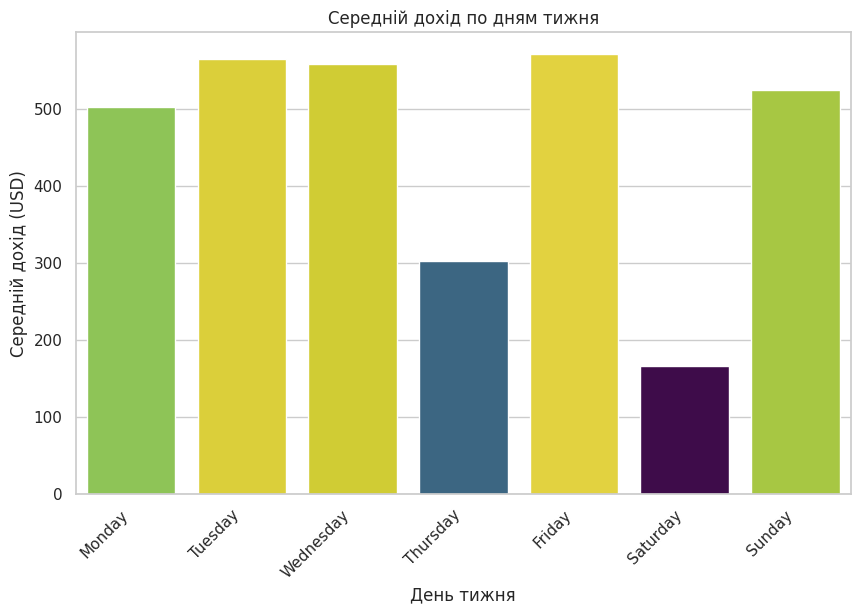

In [19]:
plt.figure(figsize=(10, 6))
sns.barplot(x="WeekdayName", y="Total", hue="Total", data=sales_per_weekday, palette="viridis", legend=False)
plt.title("Середній дохід по дням тижня")
plt.xlabel("День тижня")
plt.ylabel("Середній дохід (USD)")
plt.xticks(rotation=45, ha="right")
plt.show()

#### Агрегація даних по місяцям та розкладання часового ряду на тренд, сезонність та залишки

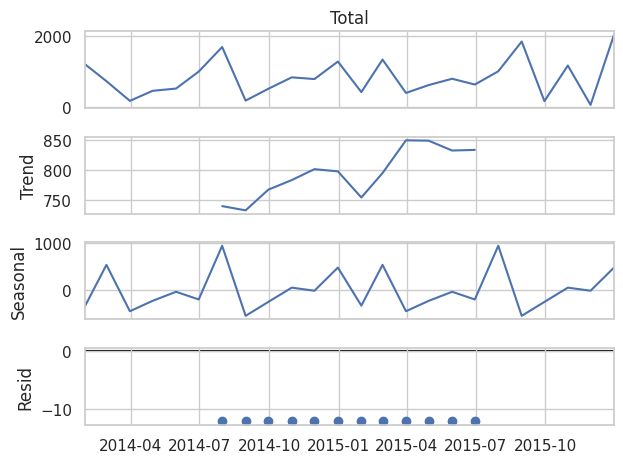

In [20]:
me = df.resample("ME").sum()
decomposition = seasonal_decompose(me["Total"], model="additive", period=12)
decomposition.plot()
plt.show()

#### Щомісячний дохід за весь період

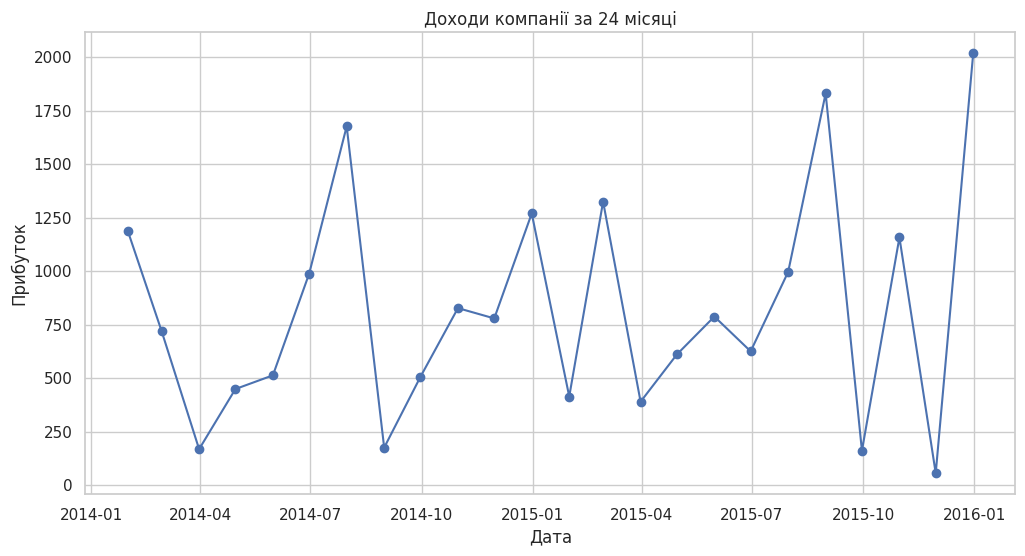

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(me["Total"], marker="o")
plt.title("Доходи компанії за 24 місяці")
plt.xlabel("Дата")
plt.ylabel("Прибуток")
plt.grid(True)
plt.show()

#### Експоненціальне згладжування для спроби прогнозування

In [22]:
model_hw = ExponentialSmoothing(me["Total"], trend="add", seasonal="add", seasonal_periods=12)
fit_hw = model_hw.fit(optimized=True)
fitted_values = fit_hw.fittedvalues

forecast_periods = 6
forecast_hw = fit_hw.forecast(forecast_periods)
future_dates = pd.date_range(start=me.index[-1] + pd.offsets.MonthEnd(1), periods=forecast_periods, freq="ME")
forecast_hw.index = future_dates

print("Прогноз доходу на наступні 6 місяців:")
forecast_hw

Прогноз доходу на наступні 6 місяців:


2016-01-31     632.765636
2016-02-29    1457.240052
2016-03-31     495.545540
2016-04-30     727.438276
2016-05-31     922.814734
2016-06-30     793.690512
Freq: ME, dtype: float64

#### Графік реальних даних, моделі та прогнозу на 6 місяців

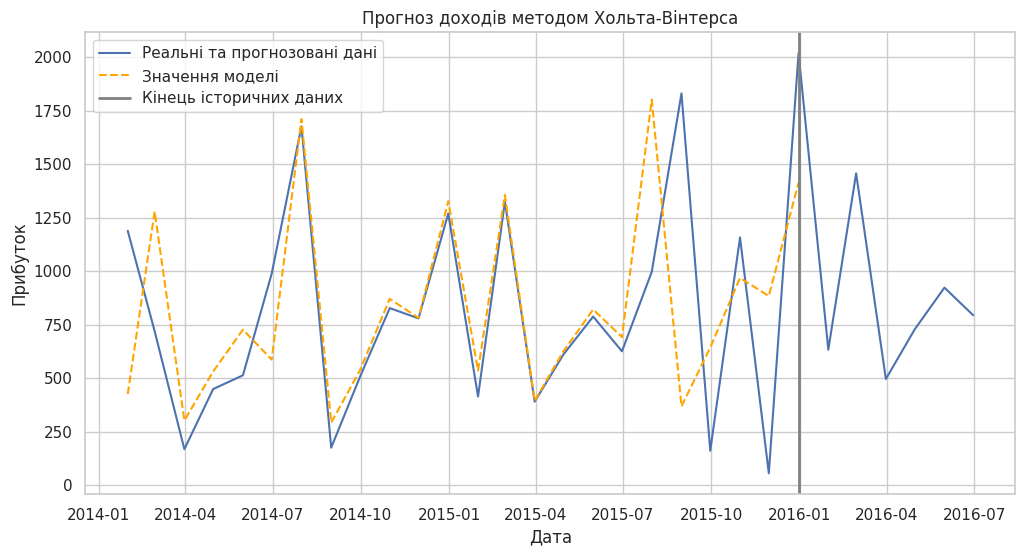

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(me.index.append(forecast_hw.index), pd.concat([me["Total"], forecast_hw]), label="Реальні та прогнозовані дані")
plt.plot(fit_hw.fittedvalues.index, fitted_values, color="orange", linestyle="--", label="Значення моделі")
plt.axvline(x=me.index[-1], color="grey", linewidth=2, label="Кінець історичних даних")
plt.title("Прогноз доходів методом Хольта-Вінтерса")
plt.xlabel("Дата")
plt.ylabel("Прибуток")
plt.legend()
plt.grid(True)
plt.show()